# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.



**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## 1. Подготовка данных

Импортируем все необходимые библиотеки

In [28]:
import pandas as pd
import numpy as np
import re 
import time
import matplotlib.pyplot as plt
from tqdm import notebook
#from pymystem3 import Mystem
import nltk
nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords as nltk_stopwords
from textblob import TextBlob, Word
#from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score 
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to C:\Users\Андрей и
[nltk_data]     Алинушка\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Андрей и
[nltk_data]     Алинушка\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Андрей и
[nltk_data]     Алинушка\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Сохраним датасет в переменной `data`

In [3]:
data = pd.read_csv('toxic_comments.csv', index_col = [0])
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Создадим корпус слов

In [4]:
corpus = data['text'].values
len(corpus)



159292

<div class="alert alert-danger">
<b>1 Комментарий ревьюера ❌:</b> 
    
`Unicode` для английского языка не требуется, но занимает доп. память, из-за чего ядро может падать

<div class="alert alert-success">
<b>2 Комментарий ревьюера ✔️:</b> 
    
Верно!

Создадим функцию по очистке данных       


In [5]:
def clear_text(text):
    clear = re.sub(r'[^a-zA-Z ]', ' ', text) 
    clear = clear.split()
    clear = " ".join(clear)
    return clear

<div class="alert alert-success">
<b>1 Комментарий ревьюера ✔️:</b> 
    
Правильная очистка!

создадим список и передадим в него очищенные и лемматизированные данные

In [6]:
lemm=[]

for i in notebook.tqdm(range(len(corpus))):
    s = TextBlob(corpus[i])
    lemm.append(" ".join([w.lemmatize() for w in s.words]))
# создадим столбец с очищенными и лемматизированными данными
data['lemm_text']=pd.Series(lemm, index=data.index)

  0%|          | 0/159292 [00:00<?, ?it/s]

<div class="alert alert-danger">
<b>1 Комментарий ревьюера ❌:</b> 
    
`WordNetLemmatizer` лемматизирует слова, а не текст целиком.
    
Статья про лемматизацию: https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/

<div class="alert alert-info"> <b> Исправлено </font></div></font>


<div class="alert alert-success">
<b>2 Комментарий ревьюера ✔️:</b> 
    
Хорошо

Посмотрим на распределение классов в данных

In [8]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

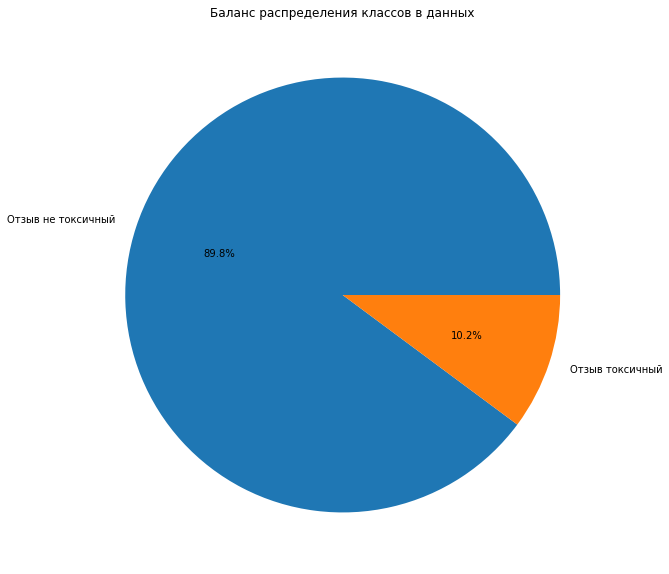

In [9]:
data['toxic'].value_counts(normalize=True).plot(kind='pie',figsize=[10,10], legend=False, autopct='%1.1f%%',labels=['Отзыв не токсичный','Отзыв токсичный'])
plt.title('Баланс распределения классов в данных')
plt.ylabel('')
plt.show()

<div class="alert alert-success">
<b>1 Комментарий ревьюера ✔️:</b> 
    
Дисбаланс обнаружен в таргете!

Разобьем наш датасет на тренировочный и тестовый, чтобы убрать дисбаланс классов воспользуемся параметром `stratify`

In [10]:
features=data.drop('toxic',axis=1)
target=data['toxic']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                            random_state=42, shuffle=True,stratify=target)

Удалим ненужные датасеты, чтобы осоводить память

In [11]:
del data, features, target

### Используем технологию `TF-IDF` для обработки наших данных, а так же отфильтруем содержимое при помощи библиотеки `nltk`


Загрузим библиотеку и стоп-слова из английского языка

In [12]:
stop_words = set(nltk_stopwords.words('english')) 

Применим модель `TfidfVectorizer` и обучим её на наших тренировочных данных

In [13]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words) 
corpus_train = features_train['lemm_text'].values.astype('U')
tf_idf_train = count_tf_idf.fit_transform(corpus_train) 
tf_idf_train

<119469x154508 sparse matrix of type '<class 'numpy.float64'>'
	with 3365242 stored elements in Compressed Sparse Row format>

<div class="alert alert-success">
<b>1 Комментарий ревьюера ✔️:</b> 
    
Нет утечки тестовых данных! Здорово, что ты не забываешь про `stop_words`

Создадим так же корпус слов и для тестовой выборки

In [14]:
corpus_test = features_test['lemm_text'].values.astype('U')
tf_idf_test = count_tf_idf.transform(corpus_test) 
tf_idf_test

<39823x154508 sparse matrix of type '<class 'numpy.float64'>'
	with 1081004 stored elements in Compressed Sparse Row format>

In [15]:
# Снова удалим ненужные переменные
del features_train, features_test, corpus_train, corpus_test

# Вывод
Мы загрузили и подготовили данные, провели очищение и лемматизацию данных. А так же обработали наши данные с помощью технологии `TF-IDF`, разделили данные на тренировочные и тестовые, выделели целевой признак. Теперь у нас все готово к обучению моделей

## 2. Обучение

<div class="alert alert-warning">
<b>1 Комментарий ревьюера ⚠️:</b> 
    
Немного про утечку тестовых данных (совет): если делать кросс-валидацию на признаках TF-IDF - произойдет утечка тестовых данных. Чтобы не попадала информация о словах из тест. выборки в тренировочную, мы обучаем `TfidfVectorizer` на тренировочной выборке, после чего трансформируем тест. выборку. <br>**Но наша ситуация при кросс-валидации**: тренировочная выборка делится на тренировочные фолды и тестовый фолд, при этом `TfidfVectorizer` обучался на всех фолдах в сумме. Решение проблемы: [Pipelines](https://stackoverflow.com/questions/46010617/do-i-use-the-same-tfidf-vocabulary-in-k-fold-cross-validation), где получение признаков `TF-IDF` происходит каждый раз, когда выборка делится на тренировочные и тестовые фолды 

```python
from sklearn.feature_extraction.text import CountVectorizer

pipeline = Pipeline([
           ('vect', TfidfVectorizer()),
           ('clf', SGDClassifier()),
])
parameters = [{
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2), (1,3),)  
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2', None),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (10, 50, 80)
},{
    'vect': (CountVectorizer(),)
    # count_vect_params...
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (10, 50, 80)
}]

grid_search = GridSearchCV(pipeline, parameters)
```

</div>


<div class="alert alert-info"> К своему стыду я пока не смогла разобраться с работой pipeline, в курсе практикума это не обсуждается, а время на  дополнительное изучения яндекс своими жесткими дедлайнами не оставляет. Я дополнила ваш код последней строкой, как мы обычно работаем с GridSearchCV, но у меня вылазиет ошибка. Пока не могу понеять технологию работы этого инструмента<b> 

```python
from sklearn.feature_extraction.text import CountVectorizer

pipeline = Pipeline([
           ('vect', TfidfVectorizer()),
           ('clf', SGDClassifier()),
])
parameters = [{
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2), (1,3),)  
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2', None),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (10, 50, 80)
},{
    'vect': (CountVectorizer(),)
    # count_vect_params...
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (10, 50, 80)
}]

grid_search = GridSearchCV(pipeline, parameters)
grid_search.fit(tf_idf_train, target_train)
```

</div>

<div class="alert alert-warning">
<b>2 Комментарий ревьюера ⚠️:</b> 

Скорее всего дело в том, что ты передаешь не текст, а TF-IDF признаки для обучения. Мы ведь при обучении автоматически из текста получаем `TF-IDF`, т.к. в `Pipeline` `TfidfVectorizer` стоит входным слоем. Т.е. схема получается такая:

`Запущен fit -> текст автоматически передается в TfidfVectorizer -> TF-IDF передается в SGDClassifier`

### Логистическая регрессия

In [22]:
%%time

model_lr = LogisticRegression(random_state=12345, solver='sag',class_weight='balanced')
parametrs_lr = { 'C': range (1, 15),
              'max_iter': range (6,15,2),
              }
lr = GridSearchCV(model_lr, parametrs_lr, cv=3, scoring='f1')
lr.fit(tf_idf_train, target_train)
f1_lr = lr.best_score_


CPU times: total: 3min 17s
Wall time: 3min 24s


Вывыедем на экран лучший результат метрики f1

In [23]:
f1_lr

0.7573989413702343

Посмотрим на параметыр лучшей модели

In [24]:
lr.best_params_

{'C': 3, 'max_iter': 10}

### "Случайный лес"

In [16]:
%%time
model_rf =  RandomForestClassifier(random_state=12345, class_weight='balanced_subsample')
grid = {'n_estimators':[10,20,30,40],
        'max_depth': [5,6,7,8,9]}
rf = GridSearchCV(model_rf, grid,cv=3, scoring='f1')
rf.fit(tf_idf_train, target_train)
f1_rf_best = rf.best_score_


CPU times: total: 7min 10s
Wall time: 7min 43s


0.3126823358315281

Вывыедем на экран лучший результат метрики f1

In [ ]:
f1_rf_best

### Модель Catboost

In [17]:
%%time


model_cat = CatBoostClassifier(random_state = 12345, verbose=50)
grid = {'iterations': [100, 150],
        'learning_rate': [0.3, 0.4],
        'depth': [2,4,6]}
model_cat_boost=GridSearchCV(model_cat, grid, scoring='f1', cv=3)
model_cat_boost.fit(tf_idf_train, target_train)
f1_cat_boost = model_cat_boost.best_score_

0:	learn: 0.4501931	total: 612ms	remaining: 1m
50:	learn: 0.1897192	total: 18.2s	remaining: 17.5s
99:	learn: 0.1679399	total: 35.8s	remaining: 0us
0:	learn: 0.4501077	total: 362ms	remaining: 35.9s
50:	learn: 0.1895848	total: 17.9s	remaining: 17.2s
99:	learn: 0.1680083	total: 34.9s	remaining: 0us
0:	learn: 0.4481245	total: 369ms	remaining: 36.5s
50:	learn: 0.1879366	total: 18.3s	remaining: 17.6s
99:	learn: 0.1653878	total: 35.3s	remaining: 0us
0:	learn: 0.3969288	total: 411ms	remaining: 40.7s
50:	learn: 0.1786432	total: 18.3s	remaining: 17.5s
99:	learn: 0.1574520	total: 35.9s	remaining: 0us
0:	learn: 0.3969185	total: 374ms	remaining: 37.1s
50:	learn: 0.1786197	total: 18.3s	remaining: 17.6s
99:	learn: 0.1567003	total: 36.3s	remaining: 0us
0:	learn: 0.3945435	total: 361ms	remaining: 35.8s
50:	learn: 0.1763139	total: 18s	remaining: 17.3s
99:	learn: 0.1541653	total: 35.3s	remaining: 0us
0:	learn: 0.4501931	total: 365ms	remaining: 54.4s
50:	learn: 0.1897192	total: 18.2s	remaining: 35.3s
100:

In [18]:
f1_cat_boost

0.735296181299141

# Вывод:
Мы обучили 3 модели:
 1. Логшистическая регрессия
 2. Случаный лес
 3. CatBoost
В результате лучший результат метрики `f1` показала модель `Логистическая регрессия`.

### 3. Проверка модели на тестовой выборке

In [26]:
best_model = LogisticRegression(random_state=12345, C = 9, max_iter = 14, solver='sag',class_weight='balanced')
best_model.fit(tf_idf_train, target_train)
predict = best_model.predict(tf_idf_test)
f1_best_model = f1_score(target_test, predict)
f1_best_model

0.7551138333525944

**На тестовой выборке наша модель показала результат f1= 0,755, что удовлетворяет условию задачи**

<div class="alert alert-success">
<b>1 Комментарий ревьюера ✔️:</b> 
    
Порог пройден!

<div class="alert alert-info"> <b> После изменения лемматизации параметр f1 уменьшился. С чем это может быть связано? </font></div></font>

<div class="alert alert-warning">
<b>2 Комментарий ревьюера ⚠️:</b> 
    
Стоит расширить сетку гиперпараметров для подбора

Посторим график тестовой выборки и предсказаний

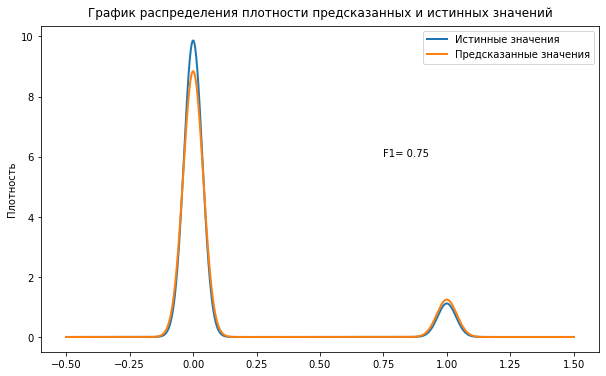

In [17]:

plt.figure(figsize=(10,6))
target_test.plot(kind='kde', linewidth=2)
pd.Series(predict).plot(kind='kde',linewidth=2)
plt.title('График распределения плотности предсказанных и истинных значений', y=1.01)
plt.legend(['Истинные значения','Предсказанные значения'])
plt.text(0.75,6,'F1= {:.2f}'.format(f1_best_model))
plt.xlabel('')
plt.ylabel('Плотность')
plt.show()

Мы видим ,что модель очень хоршо предсказывает негативные комментарии

Построим Roc-кривую и рассчитаем значение AUC-ROC

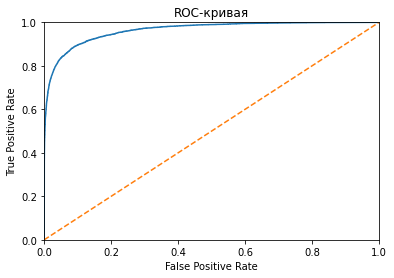

In [38]:
probabilities_valid = best_model.predict_proba(tf_idf_test)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_valid[:, 1])
plt.figure()
plt.plot(fpr, tpr)
plt.title("ROC-кривая")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

In [39]:
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
auc_roc

0.9636489086409937

Положение Roc-кривой нашей модели над roc-кривой случайной модели, а так же высокое значение параметра auc-roc говорит нам о высоком качестве нашей модели

<div class="alert alert-warning">
<b>1 Комментарий ревьюера ⚠️:</b> 
    
Более эффективно анализировать `ROC-AUC`
</div>


<div class="alert alert-success">
<b>2 Комментарий ревьюера ✔️:</b> 
    
Отлично!

# Вывод

Нашей целью было найти и обучить модель для магазина "ВИКИШОП", которая способна классифицировать комментарии на позитивные и негативные для того, чтобы в дальнейшем токсичные отзывы отправлялись на модерацию. При этом достигуть результата предсказания наилучшей модели по метрике `f1`  не меньше 0,75 

В нашем распоряжении был набор данных с разметкой о токсичности правок, но для правильной работы предсказательных алгоритмов моделей нам пришлось очистить комментарии от лишних символов и пр.мусора, а так же прибегнуть к балансировке выборок методами upsample и downsamle, т.к. сильный дисбаланс в классах мог негативно повлиять на качество предсказания моделей.

Для определения наилучшей модели мы остановили наш выбор на трёх моделях: 
 - LogisticRegression
 - RandomForestClassifier
 - Catboost
 
 По итогам сравнеиня победила модель LogisticRegression. Мы проверили эту модель на тестовой выборке и получили значение метрики `f1 = 0.762`, которое удовлетворяет условию задачи

Таким образом, для магазина "ВИКИШОП" можем рекомендовать модель LogisticRegression для модерации комментариев

<div class="alert alert-success">
<b>1 Комментарий ревьюера ✔️:</b> 
    
Вывод верно описывает проделанную работу

## 4. Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны